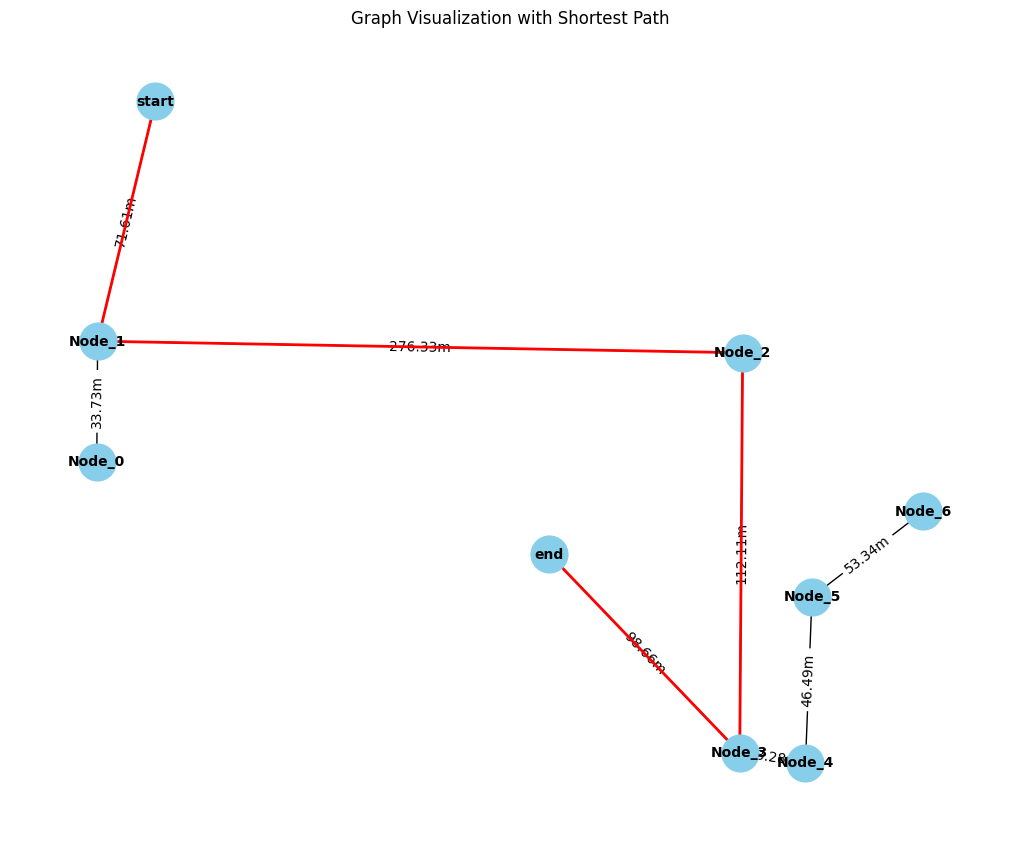

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Sample points data (replace with your actual data)
points = {
    "type": "FeatureCollection",
    "features": [
      {
        "type": "Feature",
        "properties": {"indoor": True},
        "geometry": {
          "coordinates": [
            [-113.52122913673706, 53.52501394756737],
            [-113.52072060360172, 53.52501714929542],
            [-113.52076956461727, 53.52749981891861],
            [-113.52245999968656, 53.52748874336393],
            [-113.52250118998037, 53.52774166970113],
            [-113.52180141396458, 53.52776674936845],
            [-113.52144016207536, 53.52819492073496],
          ],
          "type": "LineString"
        }
      }
    ]
}

# Create a directed or undirected graph
G = nx.Graph()

# Add nodes and edges from points data
for feature in points['features']:
    coords = feature['geometry']['coordinates']
    indoor = feature['properties'].get('indoor', False)
    for i in range(len(coords) - 1):
        pos_A = (coords[i][1], coords[i][0])
        pos_B = (coords[i + 1][1], coords[i + 1][0])
        G.add_node(f'Node_{i}', pos=pos_A)
        G.add_node(f'Node_{i + 1}', pos=pos_B)
        distance = geodesic(pos_A, pos_B).meters
        weight = distance if indoor else distance * 1.5  # Prioritize indoor paths
        G.add_edge(f'Node_{i}', f'Node_{i + 1}', weight=weight, indoor=indoor)

# Extract positions
pos = nx.get_node_attributes(G, 'pos')

def find_nearest_node(graph, lat, lon):
    min_dist = float('inf')
    nearest_node = None
    for node, (node_lat, node_lon) in pos.items():
        dist = geodesic((lat, lon), (node_lat, node_lon)).meters
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    return nearest_node

# Specify custom start and end coordinates
start_coords = (53.52523959154581, -113.51970749000677)  # Replace with your start coordinates
end_coords = (53.52675639364824, -113.52162179057186)  # Replace with your end coordinates

# Find the nearest nodes in the graph to the specified coordinates
start_node = find_nearest_node(G, *start_coords)
end_node = find_nearest_node(G, *end_coords)

# Add start and end points as nodes
G.add_node('start', pos=start_coords)
G.add_node('end', pos=end_coords)

# Ensure the positions of the start and end nodes are included in the pos dictionary
pos['start'] = start_coords
pos['end'] = end_coords

# Connect start and end points to their nearest nodes
start_distance = geodesic(start_coords, pos[start_node]).meters
end_distance = geodesic(end_coords, pos[end_node]).meters
G.add_edge('start', start_node, weight=start_distance)
G.add_edge('end', end_node, weight=end_distance)

# Find the shortest path
shortest_path = nx.shortest_path(G, source='start', target='end', weight='weight')

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]:.2f}m' for u, v, d in G.edges(data=True)})

# Highlight the shortest path
path_edges = list(zip(shortest_path, shortest_path[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)

# Show the plot
plt.title('Graph Visualization with Shortest Path')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()